In [ ]:
import torch
import networkx as nx
import numpy as np

'''
- gamma (edge penalty),
- gamma_c (clique param),
- alpha (learning rate),
- beta (momentum),
- T (number of interations to converge per initialization), and
- eta (explration parameter)
'''

'\n- gamma (edge penalty),\n- gamma_c (clique param),\n- alpha (learning rate),\n- beta (momentum),\n- T (number of interations to converge per initialization), and\n- eta (explration parameter)\n'

In [ ]:
# Graph


######## ER ###########
n = 1024
p = 0.5
G = nx.gnp_random_graph(n, p, seed=0)


# ######## d reg ###########
# n = 1000
# d = 10
# G = nx.random_regular_graph(d, n)


# compliment graph:
complement_G = nx.complement(G)

num_components = nx.number_connected_components(G)

print("Number of connected components:", num_components)

if num_components == 1:
    print("Graph has one connected component.")
else:
    print("Graph has more than one connected component.")

### Obtain the A_G matrix

adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix_dense = adjacency_matrix.todense()
adjacency_matrix_tensor = torch.tensor(adjacency_matrix_dense, dtype=torch.float32)

### Obtain the A_G_hat matrix

adjacency_matrix_comp = nx.adjacency_matrix(complement_G)
adjacency_matrix_dense_comp = adjacency_matrix_comp.todense()
adjacency_matrix_tensor_comp = torch.tensor(adjacency_matrix_dense_comp, dtype=torch.float32)

Number of connected components: 1
Graph has one connected component.


In [ ]:
### Efficient MIS Checking 2: Directly check if a binarized X is a maximal IS without checking whether it is an IS first...

def MIS_checker_efficient_3(X_torch, adjacency_matrix_tensor, adjacency_matrix_tensor_comp):
  n = X_torch.shape[0]
  # binarized X
  X_torch_binarized = X_torch.bool().float()
  # if for some gradient update, we are still at the boundary, then we have maximal IS
  X_torch_binarized_update = X_torch_binarized - 0.1*(-torch.ones(n) + (n*adjacency_matrix_tensor)@X_torch_binarized)
  # Projection to [0,1]
  X_torch_binarized_update[X_torch_binarized_update>=1] =1
  X_torch_binarized_update[X_torch_binarized_update<=0] =0
  if torch.equal(X_torch_binarized, X_torch_binarized_update):
    # we have a maximal IS:
    MIS = torch.nonzero(X_torch_binarized).squeeze()
    # Exit the function with True
    return True, MIS
  # If not a maximal IS, Exit the function with False
  return False, None

In [ ]:
### Here, we set gamma, gamma', and beta.

gamma_c = 1
degrees_c = dict(complement_G.degree())
max_degree = max(degrees_c.values())
gamma = 2 + max_degree
beta = 0.8
alpha = 0.0001
ITERATION_T = 150

In [ ]:
# Degree-based initialization:

# Calculate degrees of all nodes
degrees = dict(G.degree())

# Find the node with the maximum degree
max_degree_node = max(degrees.values())


d = torch.zeros(n)
for node, degree in G.degree():
    d[node] = 1 - (degree/max_degree_node)

d = d / max(d)
#print(d)

In [ ]:
### optimization loop using MGD


n = adjacency_matrix_tensor.shape[0]

input_velocity = torch.zeros(n)

exploration_parameter_eta = 2.0

covariance_matrix = exploration_parameter_eta*torch.eye(len(d))

# Recording Parameters
fail = 0
best = 0
N_INIT = 1

print("MGD with initial clamping.")
for init in range(N_INIT): # This iterates over initializations and run in parallel when we have GPUs

  if init == 0:
    input_tensor = d
  else:
    torch.manual_seed(init)
    input_tensor = torch.normal(mean=d, std=torch.sqrt(torch.diag(covariance_matrix)))
    # input_tensor = input_tensor.clamp(0, 1)

  for iteration in range(ITERATION_T):

      # Compute the gradient
      gradient = -torch.ones(n) + (gamma*adjacency_matrix_tensor - gamma_c*adjacency_matrix_tensor_comp)@input_tensor

      input_velocity = beta*input_velocity + alpha*gradient

      input_tensor = torch.clamp(input_tensor - input_velocity, 0, 1)

      Checker,MIS = MIS_checker_efficient_3(input_tensor, adjacency_matrix_tensor, adjacency_matrix_tensor_comp)
  if Checker:
      print("initialization: ", init, ";         MIS size = ", len(MIS))
      if len(MIS) > best:
          best = len(MIS)
  else:
      print("initialization: ", init, ";         MIS fail to be found")
      fail += 1
        # If MIS, restart from the same noise

        # Early Stopping --> Increase Iter_T
        # Compare w/o third term
        # Interior Method / Barrier Function
        # LBFGS --> 2nd order methods
        # Only one penalty (including the third term)
        # CUBOs







MGD with initial clamping.
initialization:  0 ;         MIS size =  11


In [ ]:
print("Among ", N_INIT, " runs, ", fail, " fail, and the best solution found is MIS size = ", best)

Among  1  runs,  0  fail, and the best solution found is MIS size =  11


## Run Comparison Trials ##

Comparison of no-bound, clamping, and k-factor tunable sigmoiding

Per-Seed Results:


,seed,no_bound_succ,no_bound_best,clamp_succ,clamp_best,sigmoid_k1.0_succ,sigmoid_k1.0_best,sigmoid_k0.1_succ,sigmoid_k0.1_best,sigmoid_k0.5_succ,...,sigmoid_k5.0_succ,sigmoid_k5.0_best,sigmoid_k10.0_succ,sigmoid_k10.0_best,sigmoid_k20.0_succ,sigmoid_k20.0_best,sigmoid_k50.0_succ,sigmoid_k50.0_best,sigmoid_k100.0_succ,sigmoid_k100.0_best
0,0,50,12,50,13,48,12,50,12,50,...,47,12,49,12,48,13,50,12,46,12
1,1,50,12,47,13,47,13,47,11,47,...,49,13,49,13,46,13,47,13,46,13
2,2,50,12,49,13,49,12,50,12,50,...,49,13,49,12,49,12,50,14,49,14
3,3,49,12,49,13,48,13,49,12,48,...,49,12,48,13,49,12,48,13,48,13
4,4,50,12,50,12,49,12,50,11,49,...,48,12,50,12,50,12,48,13,49,13
5,5,50,13,48,13,50,12,49,12,48,...,48,13,47,13,50,13,49,12,48,13
6,6,50,13,50,13,50,14,50,12,49,...,50,13,50,13,48,13,50,13,50,13
7,7,50,13,50,13,49,12,49,12,50,...,48,12,48,13,48,12,49,12,48,13
8,8,50,12,47,12,48,12,43,12,48,...,47,12,47,13,49,13,47,13,47,12
9,9,50,12,49,12,50,12,49,11,49,...,48,12,50,13,48,12,48,12,47,12



Averages over 50 Graphs:


,seed,no_bound_succ,no_bound_best,clamp_succ,clamp_best,sigmoid_k1.0_succ,sigmoid_k1.0_best,sigmoid_k0.1_succ,sigmoid_k0.1_best,sigmoid_k0.5_succ,...,sigmoid_k5.0_succ,sigmoid_k5.0_best,sigmoid_k10.0_succ,sigmoid_k10.0_best,sigmoid_k20.0_succ,sigmoid_k20.0_best,sigmoid_k50.0_succ,sigmoid_k50.0_best,sigmoid_k100.0_succ,sigmoid_k100.0_best
0,24.5,49.88,12.52,48.28,12.84,47.94,12.68,48.7,12.08,47.9,...,48.26,12.56,48.2,12.76,48.5,12.62,48.28,12.62,48.14,12.7


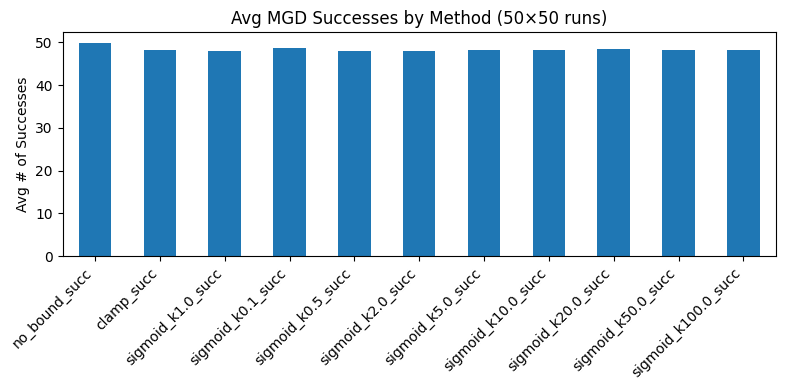

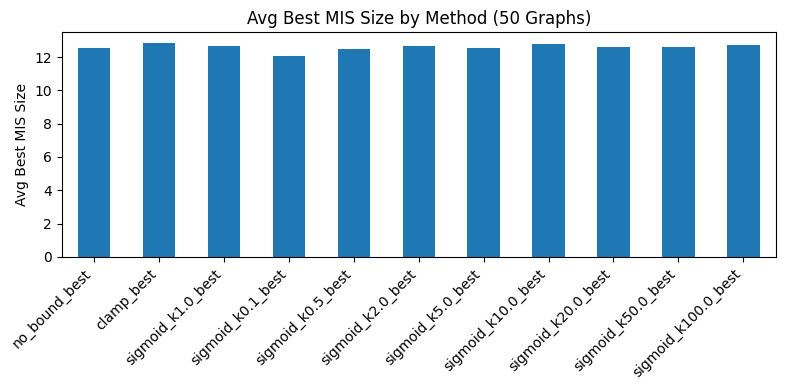

    seed  no_bound_succ  no_bound_best  clamp_succ  clamp_best  sigmoid_k1.0_succ  sigmoid_k1.0_best  sigmoid_k0.1_succ  sigmoid_k0.1_best  sigmoid_k0.5_succ  sigmoid_k0.5_best  sigmoid_k2.0_succ  sigmoid_k2.0_best  sigmoid_k5.0_succ  sigmoid_k5.0_best  sigmoid_k10.0_succ  sigmoid_k10.0_best  sigmoid_k20.0_succ  sigmoid_k20.0_best  sigmoid_k50.0_succ  sigmoid_k50.0_best  sigmoid_k100.0_succ  sigmoid_k100.0_best
0      0             50             12          50          13                 48                 12                 50                 12                 50                 13                 47                 12                 47                 12                  49                  12                  48                  13                  50                  12                   46                   12
1      1             50             12          47          13                 47                 13                 47                 11                 47             

,seed,no_bound_succ,no_bound_best,clamp_succ,clamp_best,sigmoid_k1.0_succ,sigmoid_k1.0_best,sigmoid_k0.1_succ,sigmoid_k0.1_best,sigmoid_k0.5_succ,sigmoid_k0.5_best,sigmoid_k2.0_succ,sigmoid_k2.0_best,sigmoid_k5.0_succ,sigmoid_k5.0_best,sigmoid_k10.0_succ,sigmoid_k10.0_best,sigmoid_k20.0_succ,sigmoid_k20.0_best,sigmoid_k50.0_succ,sigmoid_k50.0_best,sigmoid_k100.0_succ,sigmoid_k100.0_best
0,0,50,12,50,13,48,12,50,12,50,13,47,12,47,12,49,12,48,13,50,12,46,12
1,1,50,12,47,13,47,13,47,11,47,13,46,13,49,13,49,13,46,13,47,13,46,13
2,2,50,12,49,13,49,12,50,12,50,12,50,13,49,13,49,12,49,12,50,14,49,14
3,3,49,12,49,13,48,13,49,12,48,12,47,13,49,12,48,13,49,12,48,13,48,13
4,4,50,12,50,12,49,12,50,11,49,12,50,13,48,12,50,12,50,12,48,13,49,13
5,5,50,13,48,13,50,12,49,12,48,12,49,12,48,13,47,13,50,13,49,12,48,13
6,6,50,13,50,13,50,14,50,12,49,12,50,13,50,13,50,13,48,13,50,13,50,13
7,7,50,13,50,13,49,12,49,12,50,12,49,12,48,12,48,13,48,12,49,12,48,13
8,8,50,12,47,12,48,12,43,12,48,13,47,13,47,12,47,13,49,13,47,13,47,12
9,9,50,12,49,12,50,12,49,11,49,12,46,12,48,12,50,13,48,12,48,12,47,12


from matplotlib import pyplot as plt
df['seed'].plot(kind='hist', bins=20, title='seed')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['no_bound_succ'].plot(kind='hist', bins=20, title='no_bound_succ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['no_bound_best'].plot(kind='hist', bins=20, title='no_bound_best')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['clamp_succ'].plot(kind='hist', bins=20, title='clamp_succ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='seed', y='no_bound_succ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='no_bound_succ', y='no_bound_best', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='no_bound_best', y='clamp_succ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='clamp_succ', y='clamp_best', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['seed']
  ys = series['no_bound_succ']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('seed', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('seed')
_ = plt.ylabel('no_bound_succ')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['seed']
  ys = series['no_bound_best']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('seed', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('seed')
_ = plt.ylabel('no_bound_best')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['seed']
  ys = series['clamp_succ']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('seed', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('seed')
_ = plt.ylabel('clamp_succ')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['seed']
  ys = series['clamp_best']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('seed', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('seed')
_ = plt.ylabel('clamp_best')

from matplotlib import pyplot as plt
df['seed'].plot(kind='line', figsize=(8, 4), title='seed')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['no_bound_succ'].plot(kind='line', figsize=(8, 4), title='no_bound_succ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['no_bound_best'].plot(kind='line', figsize=(8, 4), title='no_bound_best')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['clamp_succ'].plot(kind='line', figsize=(8, 4), title='clamp_succ')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import torch
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def compare_methods_for_graph(n, p, graph_seed,
                              N_INIT=50, ITER=150,
                              alpha=1e-4, beta=0.8, eta=2.0, gamma_c=1,
                              k_values=(0.5, 1.0, 2.0, 5.0)):
    """
    Compare:
      - no_bound
      - clamp
      - sigmoid (k=1)
      - sigmoid(k*x) for each k in k_values
    Returns dict of stats for this graph seed.
    """
    # Build ER graph and its complement
    G      = nx.gnp_random_graph(n, p, seed=graph_seed)
    assert nx.number_connected_components(G) == 1
    G_comp = nx.complement(G)

    # Adjacency tensors
    A      = torch.tensor(nx.adjacency_matrix(G).todense(),       dtype=torch.float32)
    A_comp = torch.tensor(nx.adjacency_matrix(G_comp).todense(), dtype=torch.float32)

    # Penalty gamma
    max_deg = max(dict(G_comp.degree()).values())
    gamma   = 2 + max_deg

    # Degree‐based init vector d
    degs = dict(G.degree())
    d = torch.zeros(n)
    md = max(degs.values())
    for v, dv in degs.items():
        d[v] = 1 - (dv / md)
    d /= d.max()
    c = d.mean()

    # Covariance for exploration
    cov = eta * torch.eye(n)

    # Efficient MIS checker
    def mis_checker(x):
        xb    = x.bool().float()
        xb_up = xb - 0.1 * (-torch.ones_like(xb) + (n * A) @ xb)
        xb_up.clamp_(0, 1)
        return torch.equal(xb, xb_up)

    # Build method dict
    methods = {
        "no_bound": lambda x: x,
        "clamp":    lambda x: x.clamp(0, 1),
    }
    # default sigmoid (k=1)
    methods["sigmoid_k1.0"] = lambda x: torch.sigmoid(x - c)
    # tunable k-sigmoids
    for k in k_values:
        if k != 1.0:  # we already added k=1.0
            methods[f"sigmoid_k{k}"] = (lambda k: (lambda x: torch.sigmoid(k * (x - c))))(k)

    stats = {"seed": graph_seed}
    for name, bound_fn in methods.items():
        fail_count = 0
        best_size  = 0
        for init in range(N_INIT):
            # initialize
            if init == 0:
                x = d.clone()
            else:
                torch.manual_seed(init)
                x = torch.normal(mean=d, std=torch.sqrt(torch.diag(cov)))
                x = bound_fn(x)

            velocity = torch.zeros(n)
            found    = False

            for _ in range(ITER):
                grad     = -torch.ones(n) + (gamma * A - gamma_c * A_comp) @ x
                velocity = beta * velocity + alpha * grad
                x        = torch.clamp(x - velocity, 0, 1)
                if mis_checker(x):
                    found   = True
                    size    = x.bool().sum().item()
                    best_size = max(best_size, size)
                    break

            if not found:
                fail_count += 1

        stats[f"{name}_succ"] = N_INIT - fail_count
        stats[f"{name}_best"] = best_size

    return stats

# ───────────────────────── Run it ─────────────────────────
n, p = 1024, 0.5
k_values = (0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0)  # choose your k-factors here
results = [
    compare_methods_for_graph(n, p, seed, k_values=k_values)
    for seed in range(50)
]
df = pd.DataFrame(results)

# 1) Full table
print("Per-Seed Results:")
display(df)

# 2) Averages
avg_df = df.mean(numeric_only=True).to_frame().T
print("\nAverages over 50 Graphs:")
display(avg_df)

# 3) Plot avg successes
method_names = [c for c in df.columns if c.endswith("_succ")]
avg_succ = avg_df[method_names].iloc[0]
plt.figure(figsize=(8,4))
avg_succ.plot.bar()
plt.ylabel("Avg # of Successes")
plt.title("Avg MGD Successes by Method (50×50 runs)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) Plot avg best MIS size
method_names = [c for c in df.columns if c.endswith("_best")]
avg_best = avg_df[method_names].iloc[0]
plt.figure(figsize=(8,4))
avg_best.plot.bar()
plt.ylabel("Avg Best MIS Size")
plt.title("Avg Best MIS Size by Method (50 Graphs)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5) Visualization part
# 1. Print df as string
print(df.to_string())

# 2. Locally display full df
with pd.option_context(
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    display(df)

